# Load & Info & Data Preprocessing

In [149]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the sessions dataset
X = pd.read_csv('../data/train_merge_tfidf.csv')
y = pd.read_csv('../data/y.csv')

## selector3

In [150]:
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest

# SelectKBest: est une methode de sélection de caractéristiques qui permet de sélectionner les K meilleures caractéristiques
# en fonction d'un test statistique 
selector3 = SelectKBest(f_classif, k=23)
selector3.fit(X, y)

selected_feature_indices = selector3.get_support(indices=True)

selected_feature_names = X.columns[selected_feature_indices]

print(selected_feature_names)

C:\Users\ayoub\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Index(['1', '2', '11', '12', '13', '76', '87', '128', '197', '246', '296',
       '320', '337', '376', '389', '394', '397', '433', '462', '473', '475',
       '479', '522'],
      dtype='object')


C:\Users\ayoub\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [5 8] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\ayoub\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


# Selected

In [151]:
selected_feature_names

Index(['1', '2', '11', '12', '13', '76', '87', '128', '197', '246', '296',
       '320', '337', '376', '389', '394', '397', '433', '462', '473', '475',
       '479', '522'],
      dtype='object')

In [152]:
X = X[selected_feature_names]

In [153]:
X = X[:20000]
y = y[:20000]

In [154]:
X.shape

(20000, 23)

In [155]:
y.shape

(20000, 1)

In [156]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=0.4, random_state=0)
X_test.shape

(8000, 23)

In [157]:
from sklearn.metrics import make_scorer

# https://www.kaggle.com/davidgasquez/ndcg-scorer

def dcg_score(y_true, y_score, k=5):
    
    """Discounted cumulative gain (DCG) at rank K.

    Parameters
    ----------
    y_true : array, shape = [n_samples]
        Ground truth (true relevance labels).
    y_score : array, shape = [n_samples, n_classes]
        Predicted scores.
    k : int
        Rank.

    Returns
    -------
    score : float
    """
    
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])

    gain = 2 ** y_true - 1

    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)


def ndcg_score(ground_truth, predictions, k=5):
    
    """Normalized discounted cumulative gain (NDCG) at rank K.

    Normalized Discounted Cumulative Gain (NDCG) measures the performance of a
    recommendation system based on the graded relevance of the recommended
    entities. It varies from 0.0 to 1.0, with 1.0 representing the ideal
    ranking of the entities.

    Parameters
    ----------
    ground_truth : array, shape = [n_samples]
        Ground truth (true labels represended as integers).
    predictions : array, shape = [n_samples, n_classes]
        Predicted probabilities.
    k : int
        Rank.

    Returns
    -------
    score : float

    Example
    -------
    >>> ground_truth = [1, 0, 2]
    >>> predictions = [[0.15, 0.55, 0.2], [0.7, 0.2, 0.1], [0.06, 0.04, 0.9]]
    >>> score = ndcg_score(ground_truth, predictions, k=2)
    1.0
    >>> predictions = [[0.9, 0.5, 0.8], [0.7, 0.2, 0.1], [0.06, 0.04, 0.9]]
    >>> score = ndcg_score(ground_truth, predictions, k=2)
    0.6666666666
    """
    
    lb = LabelBinarizer()
    lb.fit(range(predictions.shape[1] + 1))
    T = lb.transform(ground_truth)

    scores = []

    # Iterate over each y_true and compute the DCG score
    for y_true, y_score in zip(T, predictions):
        actual = dcg_score(y_true, y_score, k)
        best = dcg_score(y_true, y_true, k)
        score = float(actual) / float(best)
        scores.append(score)

    return np.mean(scores)


# NDCG Scorer function
ndcg_scorer = make_scorer(ndcg_score, needs_proba=True, k=5)

# Fiting

In [158]:
from sklearn import linear_model
from sklearn.model_selection import RandomizedSearchCV

params =  {'C':[0.0001, 0.001, 0.01]}

lr = linear_model.LogisticRegression(multi_class="multinomial",solver="lbfgs")

clf = RandomizedSearchCV(lr, params, verbose=10, n_iter=3 ,n_jobs=-1,scoring=ndcg_scorer)

In [159]:
clf.fit(X,y)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


C:\Users\ayoub\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan]
  warnings.warn(
C:\Users\ayoub\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(estimator=LogisticRegression(multi_class='multinomial'),
                   n_iter=3, n_jobs=-1,
                   param_distributions={'C': [0.0001, 0.001, 0.01]},
                   scoring=make_scorer(ndcg_score, needs_proba=True, k=5),
                   verbose=10)

In [160]:
pred_y = clf.predict_proba(X)

In [161]:
clf.best_params_

{'C': 0.0001}

In [162]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

y_target = le.fit_transform(y['target_column_name'])

y_target

array([11,  7,  7, ...,  7,  7,  7])

In [163]:
pred_y

array([[1.01275409e-07, 2.85514920e-06, 2.61283443e-06, ...,
        2.80857835e-12, 3.95283291e-01, 4.41953498e-02],
       [5.17692977e-02, 6.33879083e-02, 6.30479243e-02, ...,
        2.73992831e-02, 1.29947695e-01, 1.13780705e-01],
       [2.03656199e-03, 6.15578176e-03, 5.97755585e-03, ...,
        6.29920672e-05, 3.10773963e-01, 1.50393430e-01],
       ...,
       [5.19512067e-03, 1.24438027e-02, 1.21584150e-02, ...,
        3.33783371e-04, 2.75377843e-01, 1.55240519e-01],
       [3.29248150e-03, 8.84472442e-03, 8.61559581e-03, ...,
        1.47531561e-04, 2.93923092e-01, 1.53684520e-01],
       [1.02853457e-02, 2.06085930e-02, 2.02316554e-02, ...,
        1.15802997e-03, 2.42189864e-01, 1.53498382e-01]])

# Train ndcg score

In [164]:
from sklearn.preprocessing import LabelBinarizer

s = ndcg_score(y_target, pred_y, k=5)

s

0.8191534083673891

# Evaluation

In [165]:
pred_y = clf.predict(X)

In [166]:
from sklearn.metrics import accuracy_score, classification_report

# Evaluate the model
accuracy = accuracy_score(y, pred_y)
report = classification_report(y, pred_y)

# Print the evaluation metrics
print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')

C:\Users\ayoub\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ayoub\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.60305
Classification Report:
              precision    recall  f1-score   support

          AU       0.00      0.00      0.00        49
          CA       0.00      0.00      0.00        82
          DE       0.00      0.00      0.00        65
          ES       0.00      0.00      0.00       185
          FR       0.00      0.00      0.00       382
          GB       0.00      0.00      0.00       179
          IT       0.00      0.00      0.00       249
         NDF       0.60      1.00      0.75     12061
          NL       0.00      0.00      0.00        61
          PT       0.00      0.00      0.00        17
          US       0.00      0.00      0.00      5619
       other       0.00      0.00      0.00      1051

    accuracy                           0.60     20000
   macro avg       0.05      0.08      0.06     20000
weighted avg       0.36      0.60      0.45     20000



C:\Users\ayoub\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Submission1

In [167]:
#test csv

# Load and preprocess the test data
test_data = pd.read_csv("../data/test_merge_tfidf.csv")

test_df = pd.read_csv('../data/test_users.csv')

test_id = test_df['id'].values

test_id

# https://www.kaggle.com/kevinwu06/feature-importance-w-xgboost

pred = clf.predict_proba(test_data[selected_feature_names])

ids = []
countries = []

# Taking the 5 classes with highest probabilities

for i in range(len(test_id)):
    idx = test_id[i]
    ids += [idx] * 5
    countries += le.inverse_transform(np.argsort(pred[i])[::-1][:5]).tolist()
    
# Generate submission

sub = pd.DataFrame({"id" : ids,"country" : countries})

sub.to_csv('../data/submission_LR2_new.csv', index = False)

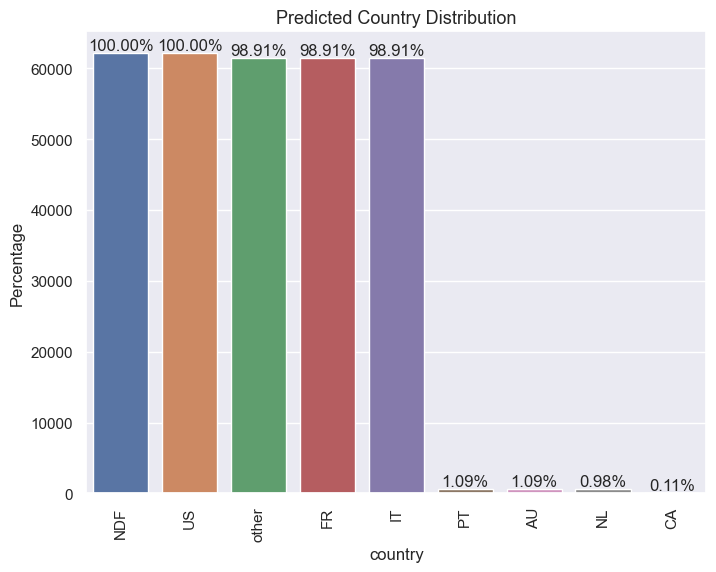

In [168]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the countplot
sns.set(style="darkgrid")
plt.figure(figsize=(8, 6))  # Optional: Set the figure size

# Calculate percentages
total_samples = len(test_data)
ax = sns.countplot(x='country', data=sub, order=sub['country'].value_counts().index)

# Add percentages to the plot
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height/total_samples*100:.2f}%', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom')

plt.title("Predicted Country Distribution", size=13)
plt.ylabel("Percentage")
plt.xticks(rotation=90)  # Optional: Rotate x-axis labels if needed
plt.show()

# Submission2

In [169]:
# from sklearn.impute import SimpleImputer
# from sklearn.preprocessing import LabelEncoder

# # Load and preprocess the test data
# test_data = pd.read_csv("../data/test_merge_tfidf.csv")

# # Predict using the trained model
# test_predictions = clf.predict(test_data[selected_feature_names])

# y['target_column_name']

In [170]:
# train_merge = y
# train_merge['country_destination'] = y['target_column_name'].astype('category')

# # Map predicted class labels to category codes
# test_data['predicted_country'] = pd.Categorical(test_predictions, categories=train_merge['country_destination'].cat.categories)

# test_data

In [171]:
# test_data['predicted_country'].unique()

In [172]:
# test_data['predicted_country'].value_counts()

In [173]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Create the countplot
# sns.set(style="darkgrid")
# plt.figure(figsize=(8, 6))  # Optional: Set the figure size

# # Calculate percentages
# total_samples = len(test_data)
# ax = sns.countplot(x='predicted_country', data=test_data, order=test_data['predicted_country'].value_counts().index)

# # Add percentages to the plot
# for p in ax.patches:
#     height = p.get_height()
#     ax.annotate(f'{height/total_samples*100:.2f}%', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom')

# plt.title("Predicted Country Distribution", size=13)
# plt.ylabel("Percentage")
# plt.xticks(rotation=90)  # Optional: Rotate x-axis labels if needed
# plt.show()

In [174]:
# submission = pd.read_csv("../data/sample_submission_NDF.csv")

In [175]:
# # Prepare submission file
# submission['country'] = test_data[['predicted_country']]

# submission.to_csv('../data/submission_LR2.csv', index=False)